<a href="https://colab.research.google.com/github/QasimWani/simple-transformer/blob/main/transformers/scaling_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
### Make attention calculation scale faster using block matrix multiplication

import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
from einops import rearrange

import matplotlib.pyplot as plt

In [2]:
# Decorator to profile a function

import functools
import time

def profile(func):
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        start = time.perf_counter()
        result = func(*args, **kwargs)
        end = time.perf_counter()
        print(f"{func.__name__} took {end - start:.6f} seconds")
        return result
    return wrapper

In [3]:
class SHA(nn.Module):

  def __init__(self, d_embed, qk_block_size, v_block_size):
    super().__init__()
    self.qkv = nn.Linear(d_embed, d_embed * 3)
    self.w_out = nn.Linear(d_embed, d_embed)

    self.qk_block_size = qk_block_size
    self.v_block_size = v_block_size

  @profile
  def ground_truth(self, x: torch.Tensor) -> torch.Tensor:
    seq_len, d_embed = x.shape
    q, k, v = rearrange(self.qkv(x), 'seq_len (d_embed three) -> three seq_len d_embed', seq_len=seq_len, d_embed=d_embed).unbind(0)
    attn = F.scaled_dot_product_attention(q, k, v)
    return self.w_out(attn)

  @profile
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    ''' Implements the default SHA solution '''
    seq_len, d_embed = x.shape
    q, k, v = rearrange(self.qkv(x), 'seq_len (d_embed three) -> three seq_len d_embed', seq_len=seq_len, d_embed=d_embed).unbind(0)

    weights = torch.einsum('QD, KD -> QK', q, k)
    scores = F.softmax(weights / d_embed ** 0.5, dim=-1)
    attn = scores @ v # query seq_len, d_embed

    return self.w_out(attn)

  def verify(self, x: torch.Tensor, alg) -> bool:
    assert torch.allclose(self.ground_truth(x), alg(x), atol=1e-6), "Mismatch solution"
    print("\nSolutions match!")

  @profile
  def block_matmul_naive(self, x: torch.Tensor) -> torch.Tensor:
    '''
    Implement block matrix multiplication
    '''
    seq_len, d_embed = x.shape

    # we need to make sure block sizes are compatible
    assert seq_len % self.qk_block_size[0] == seq_len % self.qk_block_size[1] == 0, f"QK block size not compatible with actual seq_len"
    assert self.v_block_size[0] == self.qk_block_size[1], f"Incompatible matmul"
    assert seq_len % self.v_block_size[0] == d_embed % self.v_block_size[1] == 0, f"V block size not compatible with actual seq_len, d_embed"

    q, k, v = rearrange(self.qkv(x), 'seq_len (d_embed three) -> three seq_len d_embed', seq_len=seq_len, d_embed=d_embed).unbind(0)

    weights = torch.einsum('QD, KD -> QK', q, k)
    scores = F.softmax(weights / d_embed ** 0.5, dim=-1) # q_seq_len x k_seq_len
    # apply block matmul

    # slice matrix into blocks
    # Get one qk and V block as base case, and from there build a vectorized solution
    q_block_size, k_block_size = self.qk_block_size
    v_block_size, d_block_size = self.v_block_size
    qk_block_idx_start = 0
    v_block_idx_start = 0

    out = torch.zeros_like(x) # q_seq_len, d_embed. dim to multiply across: K and V
    # ugly 3-nested loop solution
    for qs in range(0, seq_len, q_block_size):
      for ds in range(0, d_embed, d_block_size):
        for kv in range(0, seq_len, k_block_size):
          block = scores[qs : qs + q_block_size, kv : kv + k_block_size] @ v[kv: kv + k_block_size, ds : ds + d_block_size]
          out[qs : qs + q_block_size, ds : ds + d_block_size] += block

    return self.w_out(out)

  @profile
  def block_matmul_vectorized(self, x: torch.Tensor) -> torch.Tensor:
    '''
    Implement block matrix multiplication
    '''
    seq_len, d_embed = x.shape

    # we need to make sure block sizes are compatible
    assert seq_len % self.qk_block_size[0] == seq_len % self.qk_block_size[1] == 0, f"QK block size not compatible with actual seq_len"
    assert self.v_block_size[0] == self.qk_block_size[1], f"Incompatible matmul"
    assert seq_len % self.v_block_size[0] == d_embed % self.v_block_size[1] == 0, f"V block size not compatible with actual seq_len, d_embed"

    q, k, v = rearrange(self.qkv(x), 'seq_len (d_embed three) -> three seq_len d_embed', seq_len=seq_len, d_embed=d_embed).unbind(0)

    weights = torch.einsum('QD, KD -> QK', q, k)
    scores = F.softmax(weights / d_embed ** 0.5, dim=-1) # q_seq_len x k_seq_len
    # apply block matmul

    # slice matrix into blocks
    # Get one qk and V block as base case, and from there build a vectorized solution
    q_block_size, k_block_size = self.qk_block_size
    v_block_size, d_block_size = self.v_block_size
    qk_block_idx_start = 0
    v_block_idx_start = 0

    out = torch.zeros_like(x) # q_seq_len, d_embed. dim to multiply across: K and V
    scores_bqk = rearrange(scores, '(nq qs) (nk ks) -> nq nk qs ks', qs=q_block_size, ks=k_block_size) # q_block_size, k_block_size, Q / q_block_size, K / k_block_size
    v_bkd = rearrange(v, '(nk ks) (nd ds) -> nk nd ks ds', ks=v_block_size, ds=d_block_size) # vs = ks
    # scores_bqk = [nq nk qs ks], a b q k
    # v_bkd = [nk nd ks ds], b c k d
    # output = [nq qs nd ds], a q c d
    out = torch.einsum('abqk,bckd->aqcd', scores_bqk, v_bkd)
    out = rearrange(out, 'nq qs nd ds -> (nq qs) (nd ds)')
    return self.w_out(out)


In [4]:
seq_len, d_embed = 4096, 2048

data = torch.randn(seq_len, d_embed)
model = SHA(d_embed, (512, 256), (256, 512))

In [5]:
model.verify(data, model.block_matmul_naive)
model.verify(data, model.block_matmul_vectorized)
model.verify(data, model.forward)

ground_truth took 9.382324 seconds
block_matmul_naive took 5.022445 seconds

Solutions match!
ground_truth took 4.467443 seconds
block_matmul_vectorized took 4.012211 seconds

Solutions match!
ground_truth took 4.183789 seconds
forward took 4.709171 seconds

Solutions match!


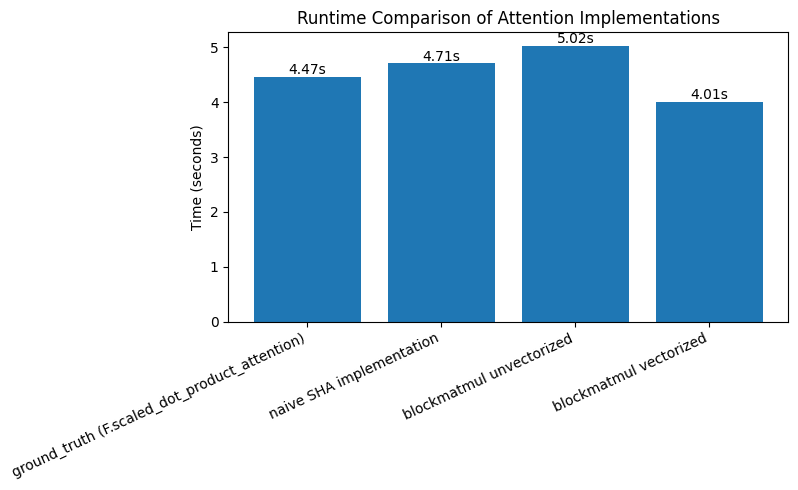

In [7]:
import matplotlib.pyplot as plt

def plot_attention_timings(ground_truth, naive, block_naive, block_vectorized):
    timings = {
        "ground_truth (F.scaled_dot_product_attention)": ground_truth,
        "naive SHA implementation": naive,
        "blockmatmul unvectorized": block_naive,
        "blockmatmul vectorized": block_vectorized,
    }
    plt.figure(figsize=(8,5))
    bars = plt.bar(timings.keys(), timings.values())
    plt.ylabel("Time (seconds)")
    plt.title("Runtime Comparison of Attention Implementations")
    plt.xticks(rotation=25, ha="right")
    for bar, value in zip(bars, timings.values()):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
                 f"{value:.2f}s", ha="center")
    plt.tight_layout()
    plt.show()

# Pasting values from the previous output cell
plot_attention_timings(
    ground_truth=4.467443,
    naive=4.709171,
    block_naive=5.022445,
    block_vectorized=4.012211
)